# Previous part here : https://www.kaggle.com/code/mohamedabder/01-eda-binary-prediction-with-a-rainfall

In [1]:
import pandas as pd
import numpy as np
from termcolor import colored

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder


#modeles :
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier


#import metrics
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import cross_val_score


import time
import pickle


from termcolor import colored
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
test = pd.read_csv("/kaggle/input/df-prep-binary-prediction-with-a-rainfall/preprocessed_test.csv", index_col = 0)
train = pd.read_csv("/kaggle/input/df-prep-binary-prediction-with-a-rainfall/train_SMOTE.csv", index_col = 0)
val = pd.read_csv("/kaggle/input/df-prep-binary-prediction-with-a-rainfall/validation.csv", index_col = 0)
df = train.copy()

In [180]:
X_train,y_train = df.drop("rainfall", axis = 1),df["rainfall"]
X_test,y_test = val.drop("rainfall", axis = 1),val["rainfall"]

# 1. Model trainig

In [181]:
def evaluer_modele(models):
    """Function for training and evaluating binary classification models.
    Displays a graph of the cross_val_score over 5 splits and returns a tuple with :
    - Trained models
    - Predictions on X_test
    - A DataFrame containing model metrics"""    
    if not isinstance(models, list):
        models = [models]
    metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-score': [], 'ROC AUC': [], 'Exe_time': []}
    predictions = {}
    trained_models = {}
    for model in models:
        model_name = model.__class__.__name__        
        # Cross-validation score
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")        
        # train
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        training_time = round(end_time - start_time, 2)
        training_time_min = round(training_time / 60, 2)
        # Predictions test set
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None        
        # metric
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
        # metric storage
        metrics['Accuracy'].append(accuracy)
        metrics['Precision'].append(precision)
        metrics['Recall'].append(recall)
        metrics['F1-score'].append(f1)
        metrics['ROC AUC'].append(roc_auc)
        metrics['Exe_time'].append(training_time_min)        
        predictions[model_name] = y_pred
        trained_models[model_name] = model        
        # cross-val score graphic
        plt.figure(figsize=(8, 3))
        sns.lineplot(x=[i+1 for i in range(len(scores))], y=scores)
        plt.xlabel('n')
        plt.ylabel('Accuracy')
        plt.title(f"{model_name}")
        plt.show()        
        print(f"average score on 5 splits : {round(scores.mean(), 2)}")
        print("-" * 30)
    # Creation of dataframe :
    metrics_df = pd.DataFrame(metrics, index=[model.__class__.__name__ for model in models])
    return trained_models, predictions, metrics_df

In [182]:
##### List of models  :
models = [
    DummyClassifier(strategy="most_frequent"),
    LogisticRegression(),
#     KNeighborsClassifier(),
#     SGDClassifier(loss="modified_huber"), 
     RandomForestClassifier(),
     AdaBoostClassifier(),
    XGBClassifier()
            ]

## 2 Cross Val Score results :

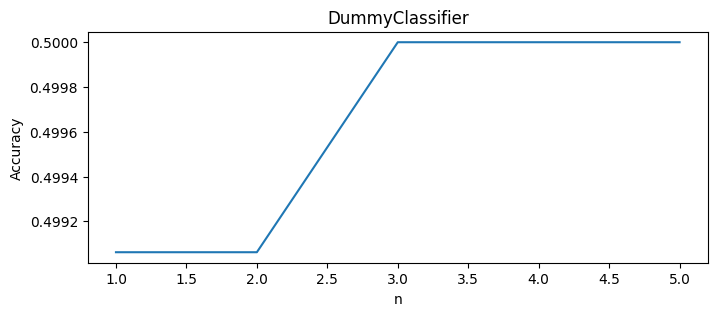

Score moyen (Accuracy) sur 5 splits : 0.5
------------------------------


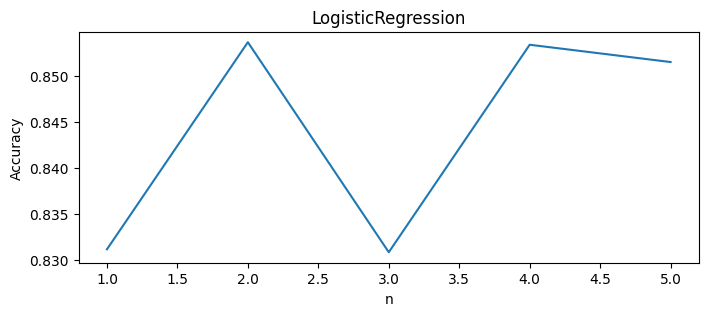

Score moyen (Accuracy) sur 5 splits : 0.84
------------------------------


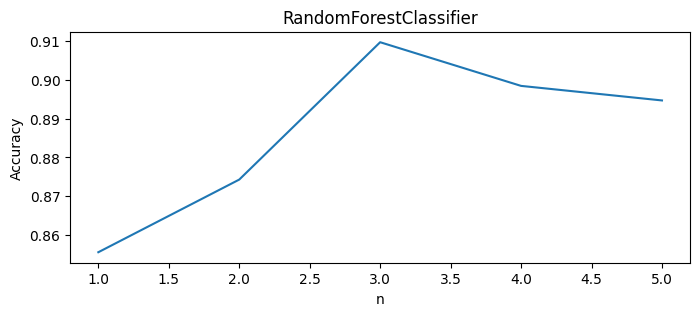

Score moyen (Accuracy) sur 5 splits : 0.89
------------------------------


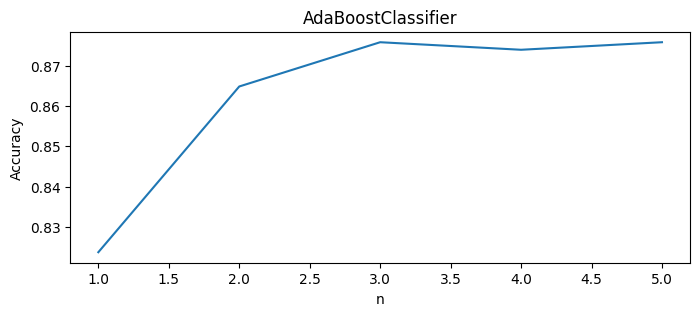

Score moyen (Accuracy) sur 5 splits : 0.86
------------------------------


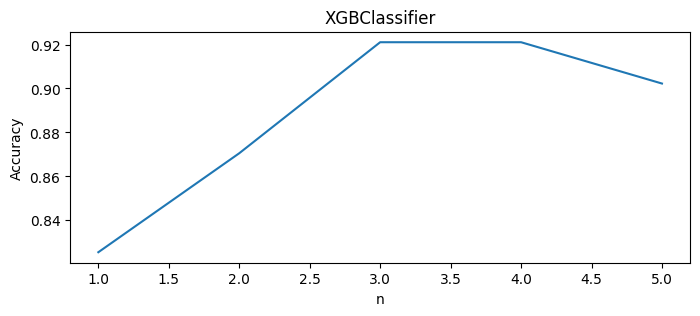

Score moyen (Accuracy) sur 5 splits : 0.89
------------------------------


In [183]:
model_trained, prediction, metric_df = evaluer_modele(models)

we can see that the models have similar results in terms of accuracy

## 2. Metrics : 

In [184]:
def vizualisation_metric(dataframe,nrow,ncol,size=(12,10)):
    """Visualisation des différentes metrics de classification"""
    plt.figure(figsize=size)
    for i,col in enumerate(dataframe,1):
        plt.subplot(nrow,ncol,i)
        plt.title(f"{col}")
        ax = sns.barplot(x = dataframe.index, y = col , data = dataframe)
        lab = ax.get_xticklabels()
        ax.set_xticklabels(labels =lab,rotation=45)
        ax.set_ylabel(None)
        plt.tight_layout()
    plt.show()

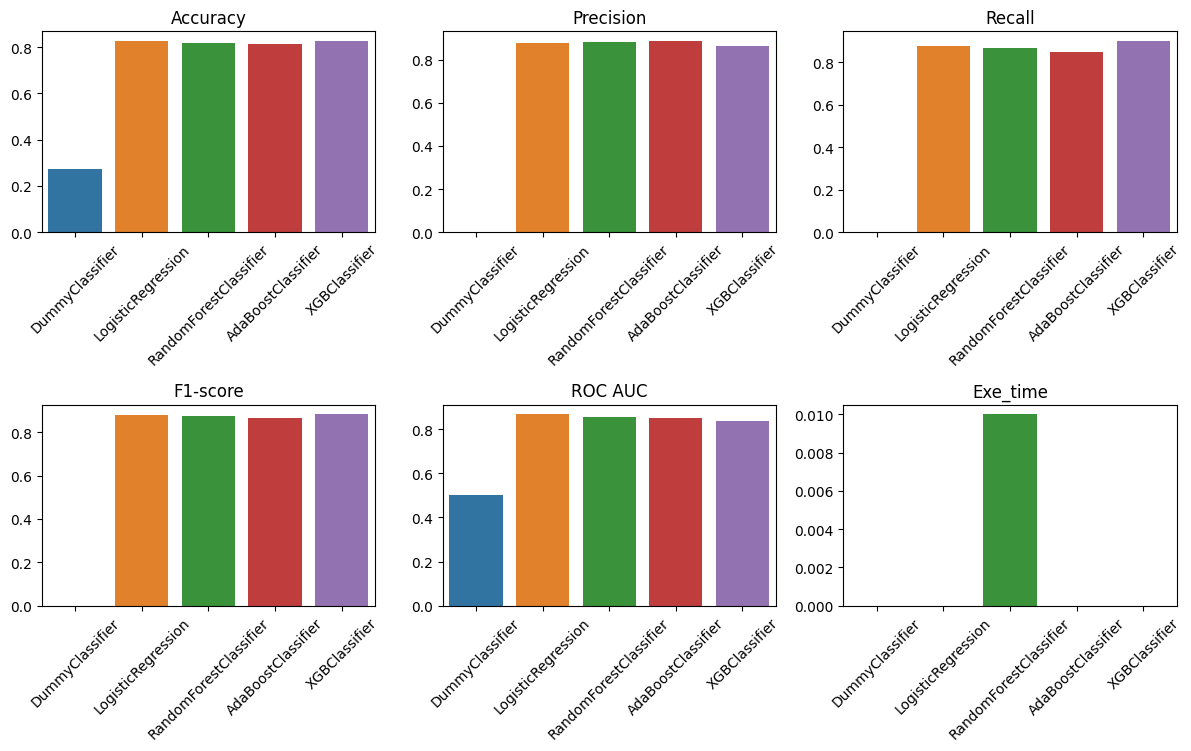

In [185]:
vizualisation_metric(metric_df, 3,3)

all the models run quickly and give very similar results

## 3. Confusion Matrix

In [186]:
def matrice(pred, nrow, ncol,size): 
    plt.figure(figsize=size)  
    for i, col in enumerate(pred, 1):
        cf = metrics.confusion_matrix(y_true=y_test, y_pred=pred[col])
        ax = plt.subplot(nrow, ncol, i)
        sns.heatmap(cf, annot=True, ax=ax,linewidths=0.8, linecolor="black",fmt=".0f", cbar=False, cmap="Blues")
        ax.set_xlabel('Prédictions')
        ax.set_ylabel('Valeurs réelles')
        ax.set_title(f"{col}")
    plt.tight_layout()  # Pour éviter les chevauchements
    plt.show()


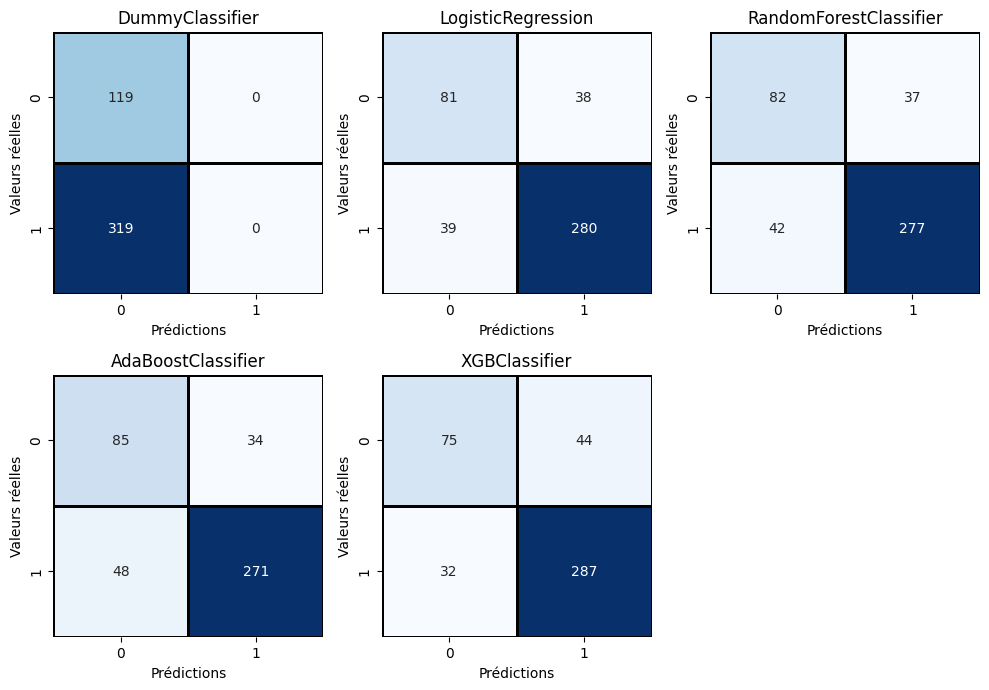

In [187]:
matrice(prediction,3,3,size=(10,10))

Depending on the model used, there will be differences in terms of recall and precision. 

 For example, the XGBoost offers better performance in terms of recall.

# 4. ROC-AUC

In [188]:
def ROC(model_list, X_test, y_test, nrow, ncol):
    """Fonction pour obtenir la courbe ROC pour plusieurs modèles de classification binaire"""
    plt.figure(figsize=(15, 10))

    # Boucle sur chaque modèle et on trace la courbe ROC dans un sous-graphique
    for i, model in enumerate(model_list):
        plt.subplot(nrow, ncol, i + 1)  # i+1 parce que subplot commence à 1

        # Prédiction des probabilités pour le modèle courant
        predicted_probabilities = model_list[model].predict(X_test)

        # Calcul de la courbe ROC et de l'AUC
        fpr, tpr, _ = roc_curve(y_test, predicted_probabilities)
        roc_auc = auc(fpr, tpr)

        # Tracé de la courbe ROC
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        
        # Ligne en pointillés représentant la performance aléatoire
        plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Aléatoire')
        
        # Ajout des légendes et des titres
        plt.legend(loc="lower right")
        plt.xlabel('Taux de faux positifs (FPR)')
        plt.ylabel('Taux de vrais positifs (TPR)')
        plt.title(f'Courbe ROC - {model}')
        plt.grid()

    plt.tight_layout()  
    plt.show()       

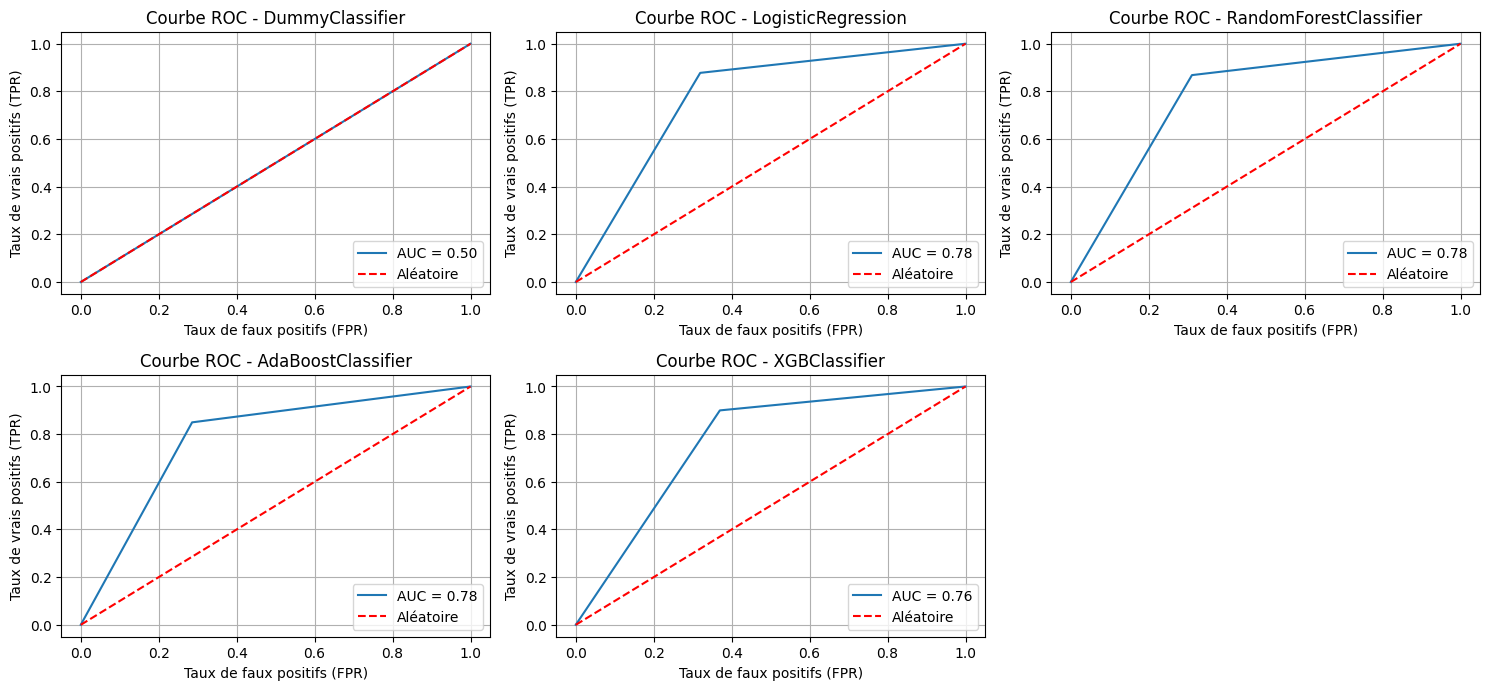

In [189]:
ROC(model_trained, X_test, y_test, 3,3)

## 5. Histogramme of prediction probability

In [190]:
def hist_predprob(models,nrow,ncol,size=(12,6)):
    """
    Créer un histogramme des probabilités de prédiction d'un modèle de classification
    models : dict modèle à analyser
    nrow, ncol : int nombre de ligne et nombre de colonnes à afficher 
    """
    plt.figure(figsize=size)
        # Vérification si models est une liste, sinon le transformer en liste
    for i, model in enumerate(models,1):
        proba = models[model].predict_proba(X_test)[:,1]
        plt.subplot(nrow,ncol,i)
        plt.xlim(0,1)
        sns.histplot(proba)
        plt.title(model)
        plt.tight_layout()
    plt.show()

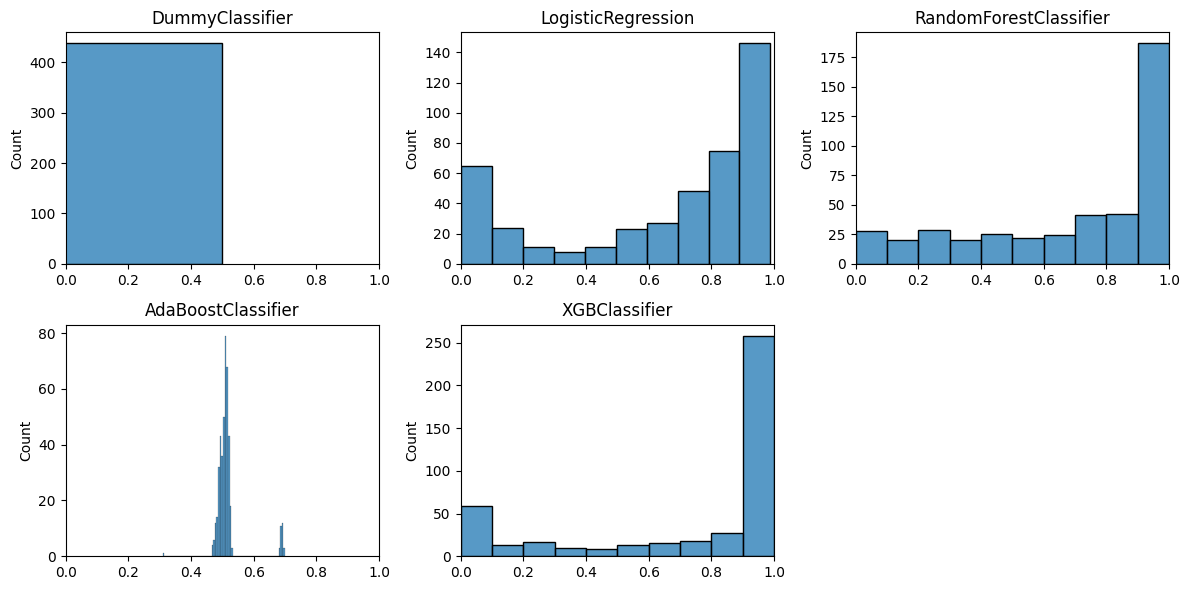

In [191]:
hist_predprob(model_trained,2,3)

Here is the probability of prediction for each class. 

Most models have predictions with a probability close to 0 or 1.

However, For example with Adaboost, the majority of predictions have a probability between 0.55 and 0.65; but if this model performs best despite probabilities often around 0.5, it is possible that it is well calibrated, even if it does not give very clear-cut predictions.


## 6. Save pretrained model 

In [192]:
def enregistrement_model(pretrained_models):
    for i in pretrained_models:
        model_name = i
        current_model = pretrained_models[model_name]
        model_filename = os.path.join(f"{model_name}.pkl")
        #Enregistrement des modèles préentrainé :
        with open(model_filename, 'wb') as model_file:
            pickle.dump(current_model, model_file)
        print(f'{colored(model_name,"blue")} enregistré sous {colored(model_filename,"green")}')


In [193]:
enregistrement_model(model_trained)

DummyClassifier enregistré sous DummyClassifier.pkl
LogisticRegression enregistré sous LogisticRegression.pkl
RandomForestClassifier enregistré sous RandomForestClassifier.pkl
AdaBoostClassifier enregistré sous AdaBoostClassifier.pkl
XGBClassifier enregistré sous XGBClassifier.pkl


## 7. Prediction in new data & Kaggle submission

In [205]:
def new_prediction(model, data):
    #Récupération des mêmes features que celles utilisés pour l'entrainement des modèles
    columns = model.feature_names_in_
    #Récupération de l'id du jeu de données
    id_data = data["id"]
    #Préparation du dataframe à tester :
    X = data[columns]
    #Récupération des prédictions
    numeric_prediction = model.predict(X)
    
    #Conversion des prédiction en données d'origine (textuelles et non numérique)
    # class_predicted = encoder_label.inverse_transform(numeric_prediction)   
    #Transformation des prédictions en dataframe avec l'id en index
    prediction_df = pd.DataFrame(numeric_prediction, columns = ["rainfall"], index = id_data)
#     prediction_df = pd.DataFrame(class_predicted, columns = ["class"], index = id_data)
    return prediction_df


In [206]:
XGB = model_trained['XGBClassifier']
lr =model_trained["LogisticRegression"]
ada = model_trained['AdaBoostClassifier']
rf = model_trained['RandomForestClassifier']

rf_df = new_prediction(model=rf,data= test)
ada_df = new_prediction(model=ada,data= test)
XGBClassifier_df = new_prediction(model=XGB,data= test)
lr = new_prediction(model=lr,data= test)


In [214]:
XGBClassifier_df.to_csv("XGBClassifier_prediction.csv")
lr.to_csv("LogisticRegression.csv")
ada_df.to_csv("ada.csv")
rf_df.to_csv("rf.csv")

# 8. Results
- With these models, we have approximatly an AUC around 76% (like training set) so we have no overfitting and good model generalisation
- We can improve performance. Here are some interesting ideas:
- In the EDA section, we removed 3 features after carrying out a hypothesis test. We could try keeping them and redoing the modelling to see whether or not performance is better.
- Next, we can run a GridSearchCV on the best model (with or without the features that were previously removed) and test it.